#### **<span style='color:darkred'>Bachelor Thesis <br/> Machine Learning in the hotel industry: an automated analysis of online guest reviews</span>**

**Supervisor:** ao. Univ.Prof. Dr. Johann Mitlöhner

**Anna Maria Berger** (h1260562)

### Part 1, Preprocessing of the data

In [25]:
!pip install sklearn
!pip install nltk
!pip install contractions
!pip install vaderSentiment
!pip install wordcloud

In [26]:

import pandas as pd
import numpy as np
import re
import csv
import sklearn
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import _stop_words
import contractions
from nltk.tokenize import RegexpTokenizer
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.tokenize import sent_tokenize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
pd.options.display.max_columns = 30
from wordcloud import WordCloud

In [27]:
import sys
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
en_stopwords=(_stop_words.ENGLISH_STOP_WORDS)
nktk=(stopwords.words('english'))

In [29]:
dataset=pd.read_csv('./data/tripadvisor_hotel_reviews.csv')

In [30]:
dataset["Review"]=(dataset["Review"]).astype(str) #review was a pd.series. for the NLP we need strings to work with

dataset["Rating"]=(dataset["Rating"]).astype(int) # the rating is supposed to be an integer, therefore changed to int

dataset


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


preprocessing the data and clean it, stopword removal, special character removal, lowercasing. no tokenizing just yet. the datasets' 'nt were somehow left with a " " in front which is then removed as well. for stopwords I used sklearn stopwords and nltk as those are a little different and we want as many stopwords with no meaning gone as possible.

In [31]:
dataset["clean"]=dataset['Review'].str.lower() 
dataset["clean"]=dataset["clean"].apply(lambda x: contractions.fix(x))
dataset["clean"] = dataset["clean"].apply(lambda s: ' '.join(re.sub("[-?:;-=/@'#_]", "", s).split()))
dataset["clean"] = dataset["clean"].apply(lambda s: ' '.join(re.sub("[*0-9]", " ", s).split()))
dataset["clean"] = dataset["clean"].apply(lambda s: ' '.join(re.sub("(w+://S+)", " ", s).split()))
dataset["clean"] = dataset["clean"].str.replace("ca nt","can not")
dataset["clean"] = dataset["clean"].str.replace("wo nt","would not")
dataset["clean"] = dataset["clean"].str.replace(" rd "," ")
dataset["clean"] = dataset["clean"].str.replace(".",". ")
dataset["clean"] = dataset["clean"].str.replace(",",".")
dataset["clean"] = dataset["clean"].str.replace(" nd "," ")
dataset["clean"] = dataset["clean"].str.replace(" st "," ")
dataset["clean"] = dataset["clean"].str.replace(" nt"," ")
#stopwords removing
dataset["clean"] = dataset["clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords) or(nktk)]))
#tokenize the sentences, is not used in the general setinment analysis though. in the general sentiment analysis the data is left without tokenizing the sentences
#you can always comment it or leave it, depending on what the purpose of the analysis is.
#but the general sentiment analysis does require the dataset where the sentences have not been tokenized.

#dataset["clean"] = dataset["clean"].apply(lambda s: sent_tokenize(s))
dataset

/tmp/ipykernel_457/105522755.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset["clean"] = dataset["clean"].str.replace(".",". ")


,Review,Rating,clean
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattle...
3,"unique, great stay, wonderful time hotel monac...",5,unique. great stay. wonderful time hotel monac...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay. went seahawk game aweso...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret time staying charm. not star ...
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,ok just looks nice modern outside. desk staff ...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...


In [32]:
dataset["clean"][45]

'great location stay long needed place stay seattle prior catching early morning amtrak train portland. looked train station not. dropping hertz car hilton downtown just wanted place spend night. called hotel seattle based location tourist map near hilton. did access internet research reviews did not stay. location great virtually door high end hotels. half price hilton thought try. checked asked aaa discount clerk response. time heard hotel desk clerk not knowing aaa. room used low budget movie version run hotel threadbare carpets dingy curtains not quite hanging right minimal lighting strange hanging light middle room dingy bathroom. definitely dingy did not appear obviously dirty. no ac luckily did need. bed not particularly comfortable little boucy people definitely gravitated middle. no clock room did wake requested. it ok spending night want spend. positive great safe location quick taxi ride train station shower great. not invested low flow shower heads water pressure really hig

dataset["clean"]=dataset["clean"].apply(lambda x: contractions.fix(x))
dataset

### Part 2, General Sentiment Analysis

In [33]:
#a small overview of the statistics offered by the "Rating" column. This does not necessarily help for the analysis but it could be interesting to compare the outcome of the sentiment analysis with the outcome of the counting
#if the results are completely different and do not make sense, something must have gone wrong with the senitment analysis

dataset["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [34]:
df=dataset["clean"].to_frame()
df.astype(str)

,clean
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not experience hotel monaco seattle...
3,unique. great stay. wonderful time hotel monac...
4,great stay great stay. went seahawk game aweso...
...,...
20486,best kept secret time staying charm. not star ...
20487,great location price view hotel great quick pl...
20488,ok just looks nice modern outside. desk staff ...
20489,hotel theft ruined vacation hotel opened sept ...


In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
# new one prints only the compound number

def polarity_detection_vader(text):
    analyzer = sid()
    vs = analyzer.polarity_scores(text)
    return float(vs['compound'])

In [36]:
def condition(r):
    if (r >=0.99):
        label = "excellent"
    elif(r>= 0.8):
        label="positive"
    elif(r <= 0.05):
        label = "negative"
    else:
        label = "neutral"
    return label

In [37]:
df["polarity"] = df["clean"].apply(lambda x: polarity_detection_vader(x))
df["classification"] = df["polarity"].apply(lambda s: condition(s))
df

,clean,polarity,classification
0,nice hotel expensive parking got good deal sta...,0.9747,positive
1,ok nothing special charge diamond member hilto...,0.9830,positive
2,nice rooms not experience hotel monaco seattle...,0.9906,excellent
3,unique. great stay. wonderful time hotel monac...,0.9946,excellent
4,great stay great stay. went seahawk game aweso...,0.9906,excellent
...,...,...,...
20486,best kept secret time staying charm. not star ...,0.9875,positive
20487,great location price view hotel great quick pl...,0.9790,positive
20488,ok just looks nice modern outside. desk staff ...,0.8122,positive
20489,hotel theft ruined vacation hotel opened sept ...,0.9628,positive


In [38]:
#would recommend to save it as the sentiment analysis takes quite long and it is better to have it saved in case the kernel stops or turns unknown
#uncomment this code when wanting to save the dataframes and changes made 
#I called it simply df

#df.to_pickle("./data/df.pkl")

In [39]:
#with open("./data/df.pkl", 'rb') as f:   
 #   df = pickle.load(f)

In [40]:
#df

In [41]:
df["classification"].value_counts()

positive     12447
excellent     4935
negative      1613
neutral       1496
Name: classification, dtype: int64

In [42]:
!pip install wordcloud

In [43]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
pd.options.display.max_columns = 30
from wordcloud import WordCloud

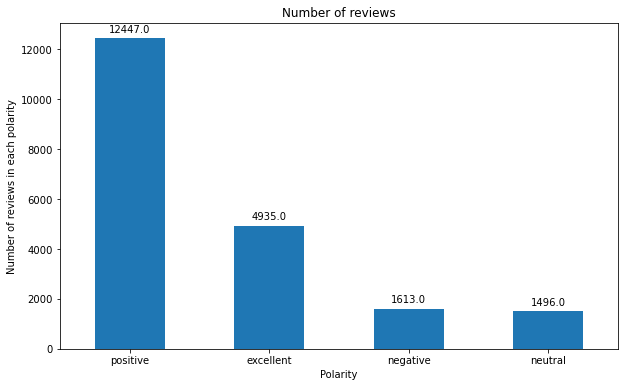

In [44]:
counter = df["classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of reviews", 
                       xlabel = "Polarity", ylabel = "Number of reviews in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

### Part 3, Sentiment and Keyword Analysis

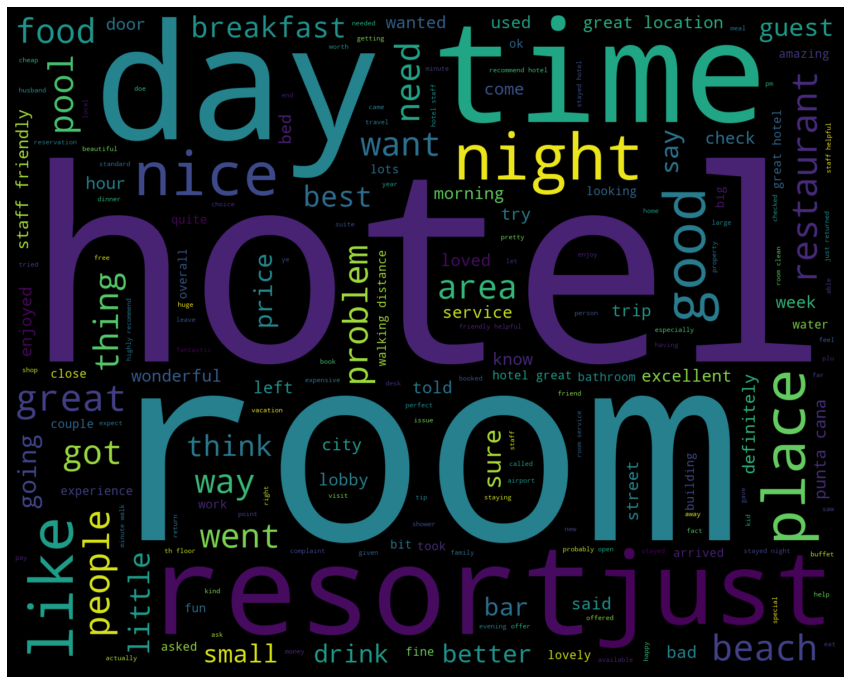

In [45]:
data=dataset
stop = ["lot", "stay", "really","look", "thought", "use","did", "make"] + list(en_stopwords)
wc = WordCloud(stopwords=stop, max_words=700, margin=10, background_color='black',
scale=3, relative_scaling = 0.4, width=500, height=400,
random_state=1).generate(' '.join(dataset['clean']))
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [46]:
from collections import Counter
Counter(" ".join(dataset["clean"]).split()).most_common(20)

[('hotel', 42306),
 ('not', 35378),
 ('room', 30834),
 ('great', 18885),
 ('staff', 15197),
 ('good', 14915),
 ('did', 14205),
 ('just', 12523),
 ('no', 11467),
 ('stay', 11407),
 ('rooms', 11175),
 ('nice', 10964),
 ('.', 10467),
 ('stayed', 10047),
 ('location', 9712),
 ('breakfast', 8732),
 ('service', 8690),
 ('beach', 8399),
 ('food', 8271),
 ('night', 7860)]

In [47]:
FnB=["breakfast", "dinner", "wine", "drinks", "food", "lunch", "main course", "eggs", "buffet", "coffee", "restaurant", "soft drinks", "cocktail", "long drink", "beer", "salad", "entre", "tea", "soup", "water", "fresh", "salt"]
rooms= ["room", "rooms", "matress", "bathroom", "bed", "beds", "toilet", "curtain", "balcony", "clean", "pillow", "soap","loud", "keycard, key", "lock", "safe", "shower", "sink", "water pressure", "hot water", "cold water", "hair dryer", "coffee maker", "blanket", "cupboard", "light", "lights", "light switch", "air condition", "heater", "carpet"]
staff= ["nice", "friendly", "helpful", "kind", "eager", "receptionist", "reception", "welcome", "waiter", "waitress", "housekeeping", "chef","service, staff", "employees", "employee", "rude", "unfriendly", "hotelier"]
spa=["clean", "pool", "sauna", "water temperature", "water", "relax", "massage", "beauty", "jacuzzi", "silent areas", "relax area", "rest room"]
hotel_general= ["reception","resort","outdoor area", "inside", "outside", "interior", "bar", "lounge", "smoking area", "exterior", "vacation", "beach", "kids club", "night", "family", "money", "price", "location", "stay", "restaurant", "airport", "payment", "cash", "lobby", "holiday", "credit card", "transfer", "transportation" ]

In [51]:
data_token=pd.DataFrame(dataset["clean"].apply(lambda s: sent_tokenize(s)))
data_token
#dataset does not tokenize sentences but includes the entire reviews, whereas the data_token is the dataset but with tokenized sentences

,clean
0,[nice hotel expensive parking got good deal st...
1,[ok nothing special charge diamond member hilt...
2,[nice rooms not experience hotel monaco seattl...
3,"[unique., great stay., wonderful time hotel mo..."
4,"[great stay great stay., went seahawk game awe..."
...,...
20486,"[best kept secret time staying charm., not sta..."
20487,[great location price view hotel great quick p...
20488,"[ok just looks nice modern outside., desk staf..."
20489,[hotel theft ruined vacation hotel opened sept...


Try k-means clustering in order to certain keywords and possible areas, if the results were good, one could use it for defining keywords.  
However, the results were giving some indication as to which areas one could pick but not enough to rely on the clusters and create keyword lists only from the keywords shown in the clusters.

In [52]:
clean_list =  list(data_token["clean"])
#first made the column a list

In [53]:
list_new = [x for xs in clean_list for x in xs]
#then made it a flat list and called it new list

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(list_new)

true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")



Top terms per cluster:
Cluster 0:
 did
 beach
 resort
 just
 nice
Cluster 1:
 hotel
 great
 location
 stayed
 recommend
Cluster 2:
 room
 clean
 view
 floor
 nice
Cluster 3:
 rooms
 clean
 small
 comfortable
 nice
Cluster 4:
 stay
 definitely
 hotel
 place
 great
Cluster 5:
 good
 food
 breakfast
 hotel
 location
Cluster 6:
 staff
 friendly
 helpful
 hotel
 great


Prediction


In [55]:
list_FnB=[]
#create the FnB list

In [56]:
for word in FnB:
    for sentence in list_new:
        if word in sentence:
            list_FnB.append(sentence)
            #append all the sentences where one or more keywords appear

In [57]:
df_FnB= pd.DataFrame(list_FnB)
df_FnB.columns = ["FnB"]
df_FnB
#make a df again for sentiment analysis

,FnB
0,took printed reservation desk showed said thin...
1,asked desk good breakfast spots neighborhood h...
2,gee best breakfast spots seattle block away co...
3,far eaten lunch look forward breakfast tomorrow.
4,ate breakfast hotel drinks loungebar times.
...,...
57919,bring because would not able shower notowels b...
57920,water warm alot salty pacific opinion.
57921,provide water pitcher saltpepper coffeetea pac...
57922,no golden saffron colored rice like eating ins...


In [58]:
list_rooms=[]

In [59]:
for word in rooms:
    for sentence in list_new:
        if word in sentence:
            list_rooms.append(sentence)
            #append all the sentences where one or more keywords appear

In [60]:
df_rooms= pd.DataFrame(list_rooms)
df_rooms.columns = ["rooms"]
df_rooms
#make a df again for sentiment analysis

,rooms
0,little disappointed nonexistent view room room...
1,not soundproof like heard music room night mor...
2,suite bedroom bathroom standard hotel room.
3,embassy suits sitting room bathroom bedroom un...
4,got nice email saying like deliver bottle cham...
...,...
108614,carpets dirty.
108615,bed worn carpeted floor littered dirt tiled ba...
108616,addition couple spots carpet fraying.
108617,another cool feature floor covered carpet mean...


In [61]:
list_staff=[]

In [62]:
for word in staff:
    for sentence in list_new:
        if word in sentence:
            list_staff.append(sentence)
            #append all the sentences where one or more keywords appear

In [63]:
df_staff= pd.DataFrame(list_staff)
df_staff.columns = ["staff"]
df_staff
#make a df again for sentiment analysis

,staff
0,nice hotel expensive parking got good deal sta...
1,little disappointed nonexistent view room room...
2,aveda bath products nice.
3,did not goldfish stay nice touch taken advanta...
4,overall nice experience having pay parking night.
...,...
35456,skill hotelier shines important aspects.
35457,family owners hotel colomba michele rosanna gr...
35458,real hoteliers hotel.
35459,hearts sank informed transferring reservation ...


In [64]:
list_spa=[]

In [65]:
for word in spa:
    for sentence in list_new:
        if word in sentence:
            list_spa.append(sentence)
            #append all the sentences where one or more keywords appear

In [66]:
df_spa= pd.DataFrame(list_spa)
df_spa.columns = ["spa"]
df_spa
#make a df again for sentiment analysis

,spa
0,little disappointed nonexistent view room room...
1,arrival no champagne strawberries no foam pill...
2,this not start hotel clean business hotel supe...
3,bathroom attractive squeaky clean small compar...
4,beds nice bathrooms clean bright pocket doors ...
...,...
27904,said decor rest room uninspired apt.
27905,rest room great.
27906,rest room ok clean valid bathroom equipped int...
27907,rest room par hotel price range certainly noth...


In [67]:
list_hotel_general=[]

In [68]:
for word in hotel_general:
    for sentence in list_new:
        if word in sentence:
            list_hotel_general.append(sentence)
            #append all the sentences where one or more keywords appear

In [69]:
df_hotel_general= pd.DataFrame(list_hotel_general)
df_hotel_general.columns = ["general_information"]
df_hotel_general
#make a df again for sentiment analysis

,general_information
0,afternoon reception serves oenophilesatisfying...
1,reception staff friendly professional room sma...
2,particularly liked reception small dog receive...
3,evening wine receptions popular.
4,wine reception boy better time walk like did l...
...,...
121702,the location great just steps market lots publ...
121703,chose price location close public transportation.
121704,however hotel lovely kind valet watched car in...
121705,tiny complaint asked man desk options terms tr...


In [70]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
# new one prints only the compound number

def polarity_detection_vader(text):
    analyzer = sid()
    vs = analyzer.polarity_scores(text)
    return float(vs['compound'])

In [71]:
def condition(r):
    if (r >=0.99):
        label = "excellent"
    elif(r>= 0.8):
        label="positive"
    elif(r== 0):
        label = "NaN"
    elif(r <= 0.05):
        label = "negative"
   
    else:
        label = "neutral"
    return label


below the polarity and classification according to the labels shown above is added using the vader sentiment analysis, same as for the entire dataset.

In [72]:
df_FnB["FnB_polarity"] = df_FnB["FnB"].apply(lambda x: polarity_detection_vader(x))
df_FnB["FnB_classification"] = df_FnB["FnB_polarity"].apply(lambda s: condition(s))
df_FnB = df_FnB[df_FnB.FnB_polarity != 0.0000]
df_FnB=df_FnB.reset_index(drop=True)

In [73]:
df_rooms["rooms_polarity"] = df_rooms["rooms"].apply(lambda x: polarity_detection_vader(x))
df_rooms["rooms_classification"] = df_rooms["rooms_polarity"].apply(lambda s: condition(s))
df_rooms = df_rooms[df_rooms.rooms_polarity != 0.0000]
df_rooms =df_rooms.reset_index(drop=True)

In [74]:
df_staff["staff_polarity"] = df_staff["staff"].apply(lambda x: polarity_detection_vader(x))
df_staff["staff_classification"] = df_staff["staff_polarity"].apply(lambda s: condition(s))
df_staff = df_staff[df_staff.staff_polarity != 0.0000]
df_staff=df_staff.reset_index(drop=True)

In [75]:
df_spa["spa_polarity"] = df_spa["spa"].apply(lambda x: polarity_detection_vader(x))
df_spa["spa_classification"] = df_spa["spa_polarity"].apply(lambda s: condition(s))
df_spa = df_spa[df_spa.spa_polarity != 0.0000]
df_spa =df_spa.reset_index(drop=True)

In [76]:
df_hotel_general["general_polarity"] = df_hotel_general["general_information"].apply(lambda x: polarity_detection_vader(x))
df_hotel_general["general_classification"] = df_hotel_general["general_polarity"].apply(lambda s: condition(s))
df_hotel_general = df_hotel_general[df_hotel_general.general_polarity != 0.0000]
df_hotel_general= df_hotel_general.reset_index(drop=True)

the numbers of each classification are counted and shown below as well as the graphs for each of the data frames.

In [77]:
print(df_FnB[ "FnB_classification"].value_counts(),"\n",
      df_rooms["rooms_classification"].value_counts(),"\n",
      df_staff["staff_classification"].value_counts(),"\n",
      df_spa["spa_classification"].value_counts(),"\n",
      df_hotel_general["general_classification"].value_counts())

neutral      28323
negative      8802
positive      7527
excellent       57
Name: FnB_classification, dtype: int64 
 neutral      51796
negative     19247
positive     14186
excellent       69
Name: rooms_classification, dtype: int64 
 neutral      22108
positive      8420
negative      3492
excellent       24
Name: staff_classification, dtype: int64 
 neutral      15297
positive      5233
negative      3151
excellent       24
Name: spa_classification, dtype: int64 
 neutral      59455
negative     17823
positive     17303
excellent       87
Name: general_classification, dtype: int64


the graphs, created usding matplotlib are created to better visualize the outcome of the sentiment analysis for each area

In [78]:
!pip install wordcloud

In [79]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
pd.options.display.max_columns = 30
from wordcloud import WordCloud

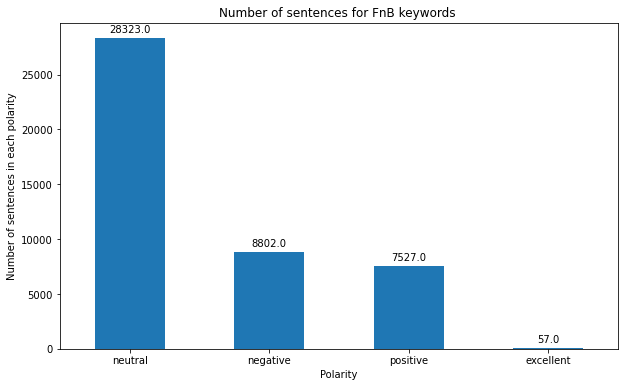

In [80]:
counter = df_FnB["FnB_classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of sentences for FnB keywords ", 
                       xlabel = "Polarity", ylabel = "Number of sentences in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

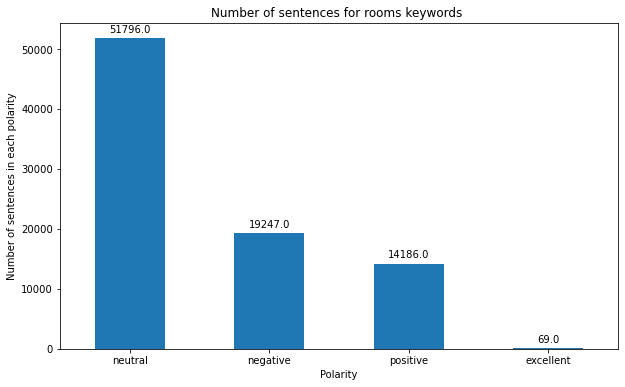

In [81]:
counter = df_rooms["rooms_classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of sentences for rooms keywords ", 
                       xlabel = "Polarity", ylabel = "Number of sentences in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

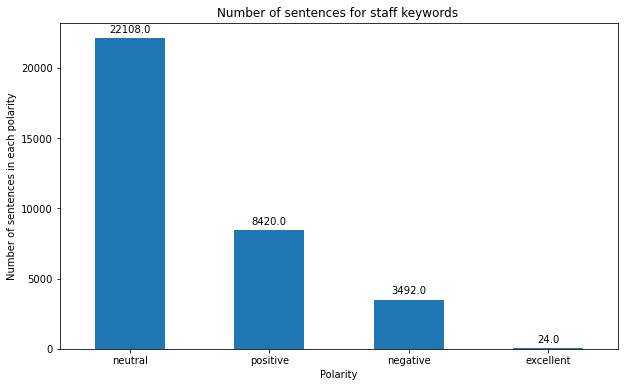

In [82]:
counter = df_staff["staff_classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of sentences for staff keywords ", 
                       xlabel = "Polarity", ylabel = "Number of sentences in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

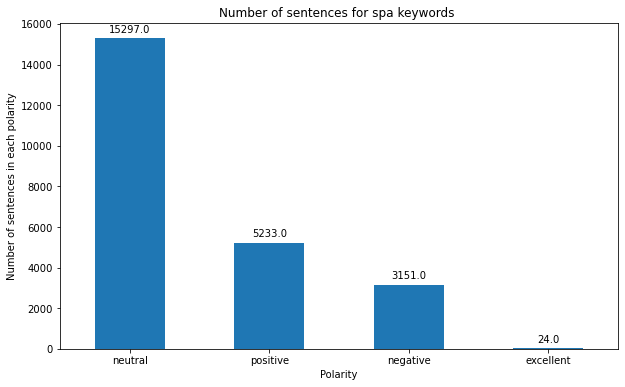

In [83]:
counter = df_spa["spa_classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of sentences for spa keywords ", 
                       xlabel = "Polarity", ylabel = "Number of sentences in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

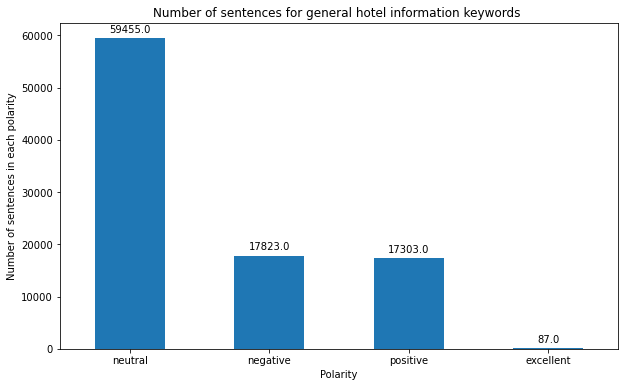

In [84]:
counter = df_hotel_general["general_classification"].value_counts() # creates a panda series which counts the number of articles in each polarity group number of their occurances in the column (shows how many articles there are in each polarity)

bar = counter.plot.bar(rot=0, title = "Number of sentences for general hotel information keywords ", 
                       xlabel = "Polarity", ylabel = "Number of sentences in each polarity")

for p in bar.patches: # annotates the bars for further clarity
    bar.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
    
plt.show()

In [85]:
print("The most occuring words in FnB are:", Counter(" ".join(df_FnB["FnB"]).split()).most_common(15),  "\n",
      "The most occuring words in rooms are:", Counter(" ".join(df_rooms["rooms"]).split()).most_common(15), "\n",
      "The most occuring words in staff are:", Counter(" ".join(df_staff["staff"]).split()).most_common(15), "\n",
      "The most occuring words in spa are:", Counter(" ".join(df_spa["spa"]).split()).most_common(15), "\n",
      "The most occuring words in general information are:", Counter(" ".join(df_hotel_general["general_information"]).split()).most_common(15))
#finding out which words occur the most in each of the selected areas.    

The most occuring words in FnB are: [('breakfast', 11861), ('food', 10928), ('not', 7585), ('good', 7460), ('hotel', 6348), ('restaurant', 5989), ('great', 5732), ('buffet', 5504), ('room', 5204), ('restaurants', 4623), ('water', 4287), ('nice', 3261), ('did', 3222), ('no', 3161), ('coffee', 3126)] 
 The most occuring words in rooms are: [('room', 38623), ('rooms', 23164), ('clean', 17265), ('hotel', 14476), ('not', 13743), ('bathroom', 10589), ('nice', 8547), ('great', 8113), ('good', 7573), ('no', 7409), ('bed', 7187), ('beds', 6224), ('comfortable', 6182), ('small', 5818), ('staff', 5707)] 
 The most occuring words in staff are: [('nice', 12164), ('staff', 11256), ('friendly', 8518), ('hotel', 7309), ('helpful', 5899), ('room', 4835), ('not', 4641), ('helpful.', 3002), ('great', 2828), ('good', 2538), ('rooms', 2323), ('clean', 2285), ('reception', 2283), ('really', 1803), ('service', 1790)] 
 The most occuring words in spa are: [('clean', 8383), ('pool', 6187), ('room', 5458), ('wa

In [ ]:
all_data=pd.concat([df_FnB, df_rooms], axis=1)
all_data=pd.concat([all_data, df_hotel_general], axis=1)
all_data=pd.concat([all_data, df_staff], axis=1)
all_data=pd.concat([all_data, df_spa], axis=1)

all_data

the following cells are currently raw and could be changed back to code cells when there is a need for saving the data

### Analysis of negative reviews from different areas

In [90]:
rooms_neg=df_rooms["rooms"].loc[df_rooms['rooms_classification'] == "negative"]
staff_neg=df_staff["staff"].loc[df_staff['staff_classification'] == "negative"]
FnB_neg=df_FnB["FnB"].loc[df_FnB['FnB_classification'] == "negative"]
spa_neg=df_spa["spa"].loc[df_spa['spa_classification'] == "negative"]
general_neg=df_hotel_general["general_information"].loc[df_hotel_general['general_classification'] == "negative"]
negative=[FnB_neg, rooms_neg, staff_neg, spa_neg, general_neg]

now, further analysis is conducted by having a look at the negative parts of the reviews as these are the ones telling the hotelier where to improve

negative

one can detect that for the food and beverages the term "breakfast" occured quite often as well as restaurant, buffet, service, coffee, drinks and dinner. However, this holds not too much information and the next step is then vectorizing the data frame with the negative parts of the reviews and extracting the keywords in form of n-grams ranging from 3-6 to get a better understanding of the context in which they appear. 

In [87]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [88]:
vectorizer = TfidfVectorizer(max_features=100,
                             ngram_range=(3,5),
                             lowercase = True)

In [91]:
for i in negative:
        vectorizer.fit_transform(i)
        print(i)
        print(vectorizer.get_feature_names_out(i))

['ala carte restaurants' 'beer soft drinks' 'breakfast lunch buffet'
 'breakfast lunch dinner' 'breakfast not good' 'breakfast not great'
 'breakfast not included' 'buffet breakfast lunch' 'buffet breakfast not'
 'buffet food not' 'buffet not good' 'can not say'
 'coffee facilities room' 'coffee maker room' 'coffee making facilities'
 'coffee making facilities room' 'coffee tea making'
 'coffee tea making facilities' 'did not breakfast' 'did not care'
 'did not eat' 'did not like' 'did not like food' 'did not look'
 'did not try' 'did not want' 'did not work' 'drink tap water'
 'eggs cold cuts' 'food buffet not' 'food did not' 'food good not'
 'food good not great' 'food not best' 'food not good' 'food not great'
 'food ok not' 'food pretty bad' 'french toast fruit'
 'frustrating breakfast lunch' 'getting ready dinner' 'good not great'
 'got food poisoning' 'got sick food' 'hard boiled eggs'
 'hot water shower' 'hotel does not' 'included room rate'
 'la carte restaurant' 'la carte rest

### Part 4, Success Factor Analysis

In [92]:
df


,clean,polarity,classification
0,nice hotel expensive parking got good deal sta...,0.9747,positive
1,ok nothing special charge diamond member hilto...,0.9830,positive
2,nice rooms not experience hotel monaco seattle...,0.9906,excellent
3,unique. great stay. wonderful time hotel monac...,0.9946,excellent
4,great stay great stay. went seahawk game aweso...,0.9906,excellent
...,...,...,...
20486,best kept secret time staying charm. not star ...,0.9875,positive
20487,great location price view hotel great quick pl...,0.9790,positive
20488,ok just looks nice modern outside. desk staff ...,0.8122,positive
20489,hotel theft ruined vacation hotel opened sept ...,0.9628,positive


In [93]:
df_excellent=df.loc[df['classification'] == "excellent"]
df_excellent

,clean,polarity,classification
2,nice rooms not experience hotel monaco seattle...,0.9906,excellent
3,unique. great stay. wonderful time hotel monac...,0.9946,excellent
4,great stay great stay. went seahawk game aweso...,0.9906,excellent
6,cozy stay rainy city. husband spent nights mon...,0.9925,excellent
16,disappointed say anticipating stay hotel monac...,0.9915,excellent
...,...,...,...
20464,loved la concha. stayed nights days la concha ...,0.9949,excellent
20468,absolutely wonderful st. regis. spg member exc...,0.9950,excellent
20471,great hotel prime location husband spent night...,0.9912,excellent
20476,night not trust not disappointed stay hotel. s...,0.9917,excellent


In [94]:
df_excellent=df_excellent.reset_index(drop=True)
Counter(" ".join(df_excellent["clean"]).split()).most_common(20)

[('not', 13167),
 ('hotel', 12471),
 ('room', 10263),
 ('great', 8350),
 ('did', 6554),
 ('good', 6034),
 ('just', 5633),
 ('staff', 5292),
 ('beach', 5262),
 ('.', 4550),
 ('nice', 4493),
 ('food', 4226),
 ('no', 3948),
 ('really', 3859),
 ('resort', 3858),
 ('day', 3689),
 ('pool', 3654),
 ('like', 3642),
 ('time', 3520),
 ('service', 3487)]

In [95]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
vectorizer = TfidfVectorizer(max_features=100,
                            # min_df=0.3,
                             ngram_range=(3,6),
                             lowercase = True)
X = vectorizer.fit_transform(df_excellent["clean"])


In [97]:
print(X.toarray())
print(X.shape)
features = vectorizer.get_feature_names_out()
len(features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4935, 100)


100

In [98]:
features

array(['ala carte restaurants', 'best hotel stayed',
       'breakfast lunch dinner', 'can not beat', 'can not comment',
       'can not imagine', 'can not remember', 'can not say',
       'can not wait', 'can not wait return',
       'definitely recommend hotel', 'did great job', 'did not bother',
       'did not eat', 'did not feel', 'did not like', 'did not sick',
       'did not try', 'did not use', 'did not want', 'did not work',
       'do not know', 'easy walking distance', 'el san juan',
       'empire state building', 'excellence punta cana',
       'excellent value money', 'feel free email', 'flat screen tv',
       'food pretty good', 'free internet access',
       'free wireless internet', 'friendly helpful staff',
       'goes long way', 'good value money', 'great hotel great',
       'great hotel great location', 'great location great',
       'great location stayed', 'great place stay', 'great value money',
       'highly recommend hotel', 'highly recommend resort',
    

In [99]:
Counter(" ".join(features).split()).most_common(20)

[('not', 23),
 ('hotel', 13),
 ('great', 12),
 ('did', 11),
 ('punta', 8),
 ('cana', 8),
 ('just', 8),
 ('room', 8),
 ('can', 7),
 ('returned', 7),
 ('staff', 6),
 ('friendly', 5),
 ('location', 5),
 ('free', 4),
 ('good', 4),
 ('helpful', 4),
 ('stay', 4),
 ('walk', 4),
 ('stayed', 3),
 ('wait', 3)]